# TransactionHistory
Predicting ActualCost

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from torch.utils.data import TensorDataset, DataLoader
from common_functions import drop_sk_datetime_added_columns as drop_columns, train_model, get_engine, \
    read_data_return_df, plot_predictions, plot_feature_importance, plot_decision_tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
import torch

## Connecting to the database

In [2]:
engine = get_engine()

Connection to UnitedOutdoors database successful


## Reading the data

In [3]:
transactionhistory_sql_query = "SELECT * FROM TransactionHistory"
transactionhistory_df = read_data_return_df(transactionhistory_sql_query, engine)

transactionhistory_df.head()

,TRANSACTIONHISTORY_sk,TRANSACTIONHISTORY_TRANSACTIONHISTORY_TransactionID,TRANSACTIONHISTORY_TRANSACTIONHISTORY_ProductID,TRANSACTIONHISTORY_TRANSACTIONHISTORY_ReferenceOrderID,TRANSACTIONHISTORY_TRANSACTIONHISTORY_ReferenceOrderLineID,TRANSACTIONHISTORY_TRANSACTIONHISTORY_TransactionDate,TRANSACTIONHISTORY_TRANSACTIONHISTORY_TransactionType,TRANSACTIONHISTORY_TRANSACTIONHISTORY_Quantity,TRANSACTIONHISTORY_TRANSACTIONHISTORY_ActualCost,TRANSACTIONHISTORY_datetime_added
0,1,100000,684,41590,0,2013-07-31,W,2,0.0,2024-05-26 17:15:23.243
1,2,100001,744,41591,0,2013-07-31,W,1,0.0,2024-05-26 17:15:23.243
2,3,100002,762,41592,0,2013-07-31,W,1,0.0,2024-05-26 17:15:23.243
3,4,100003,768,41593,0,2013-07-31,W,1,0.0,2024-05-26 17:15:23.243
4,5,100004,774,41594,0,2013-07-31,W,1,0.0,2024-05-26 17:15:23.243


In [4]:
transactionhistoryarchive_sql_query = "SELECT * FROM TransactionHistoryArchive"
transactionhistoryarchive_df = read_data_return_df(transactionhistoryarchive_sql_query, engine)

transactionhistoryarchive_df.head()

,TRANSACTIONHISTORYARCHIVE_sk,TRANSACTIONHISTORYARCHIVE_TRANSACTIONHISTORYARCHIVE_TransactionID,TRANSACTIONHISTORYARCHIVE_TRANSACTIONHISTORYARCHIVE_ProductID,TRANSACTIONHISTORYARCHIVE_TRANSACTIONHISTORYARCHIVE_ReferenceOrderID,TRANSACTIONHISTORYARCHIVE_TRANSACTIONHISTORYARCHIVE_ReferenceOrderLineID,TRANSACTIONHISTORYARCHIVE_TRANSACTIONHISTORYARCHIVE_TransactionDate,TRANSACTIONHISTORYARCHIVE_TRANSACTIONHISTORYARCHIVE_TransactionType,TRANSACTIONHISTORYARCHIVE_TRANSACTIONHISTORYARCHIVE_Quantity,TRANSACTIONHISTORYARCHIVE_TRANSACTIONHISTORYARCHIVE_ActualCost,TRANSACTIONHISTORYARCHIVE_datetime_added
0,1,1,1997,1,1,2011-04-16,P,4,50.2600,2024-05-26 18:00:08.240
1,2,2,38,2,1,2011-04-16,P,3,45.1200,2024-05-26 18:00:08.240
2,3,3,39,2,2,2011-04-16,P,3,45.5805,2024-05-26 18:00:08.240
3,4,4,203,3,1,2011-04-16,P,550,16.0860,2024-05-26 18:00:08.240
4,5,5,2000,4,1,2011-04-16,P,3,57.0255,2024-05-26 18:00:08.240


In [5]:
product_sql_query = "SELECT * FROM Product"
product_df = read_data_return_df(product_sql_query, engine)

product_df.head()

,PRODUCT_sk,PRODUCT_PRODUCT_ID,PRODUCT_UNITMEASURE_SIZE_ID,PRODUCT_UNITMEASURE_WEIGHT_ID,PRODUCT_PRODUCT_SubCategoryID,PRODUCT_PRODUCTSUBCATEGORY_CategoryID,PRODUCT_PRODUCT_ModelID,PRODUCT_PRODUCTMODELILLUSTRATION_IllustrationID,PRODUCT_PRODUCTPRODUCTPHOTO_PhotoID,PRODUCT_PMPDC_DescriptionID,...,PRODUCT_PRODUCTPHOTO_LargePhotoHexString,PRODUCT_PRODUCTPHOTO_LargePhotoFileName,PRODUCT_PRODUCT_SellStartDate,PRODUCT_DATE_SellStartDateFK,PRODUCT_PRODUCT_SellEndDate,PRODUCT_DATE_SellEndDateFK,PRODUCT_PRODUCT_DiscountedDate,PRODUCT_DATE_DiscountedDateFK,PRODUCT_PRODUCT_Discontinued,PRODUCT_datetime_added
0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,0x474946383961F0009500F70000000000800000008000...,no_image_available_large.gif,2008-04-30,20080430,None,18000101,None,18000101,NaN,2024-05-26 17:13:33.597
1,2,2,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,0x474946383961F0009500F70000000000800000008000...,no_image_available_large.gif,2008-04-30,20080430,None,18000101,None,18000101,NaN,2024-05-26 17:13:33.597
2,3,3,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,0x474946383961F0009500F70000000000800000008000...,no_image_available_large.gif,2008-04-30,20080430,None,18000101,None,18000101,NaN,2024-05-26 17:13:33.597
3,4,4,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,0x474946383961F0009500F70000000000800000008000...,no_image_available_large.gif,2008-04-30,20080430,None,18000101,None,18000101,NaN,2024-05-26 17:13:33.597
4,5,316,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,0x474946383961F0009500F70000000000800000008000...,no_image_available_large.gif,2008-04-30,20080430,None,18000101,None,18000101,NaN,2024-05-26 17:13:33.597


## Data cleaning

In [6]:
# renaming the transactionhistoryarchive columns to match the transactionhistory columns
transactionhistoryarchive_df.rename(columns={'TRANSACTIONHISTORYARCHIVE_TRANSACTIONHISTORYARCHIVE_TransactionID' : 'TRANSACTIONHISTORY_TRANSACTIONHISTORY_TransactionID', 'TRANSACTIONHISTORYARCHIVE_TRANSACTIONHISTORYARCHIVE_ProductID' : 'TRANSACTIONHISTORY_TRANSACTIONHISTORY_ProductID', 'TRANSACTIONHISTORYARCHIVE_TRANSACTIONHISTORYARCHIVE_ReferenceOrderID' : 'TRANSACTIONHISTORY_TRANSACTIONHISTORY_ReferenceOrderID', 'TRANSACTIONHISTORYARCHIVE_TRANSACTIONHISTORYARCHIVE_ReferenceOrderLineID' : 'TRANSACTIONHISTORY_TRANSACTIONHISTORY_ReferenceOrderLineID', 'TRANSACTIONHISTORYARCHIVE_TRANSACTIONHISTORYARCHIVE_TransactionDate' : 'TRANSACTIONHISTORY_TRANSACTIONHISTORY_TransactionDate', 'TRANSACTIONHISTORYARCHIVE_TRANSACTIONHISTORYARCHIVE_TransactionType' : 'TRANSACTIONHISTORY_TRANSACTIONHISTORY_TransactionType', 'TRANSACTIONHISTORYARCHIVE_TRANSACTIONHISTORYARCHIVE_Quantity' : 'TRANSACTIONHISTORY_TRANSACTIONHISTORY_Quantity', 'TRANSACTIONHISTORYARCHIVE_TRANSACTIONHISTORYARCHIVE_ActualCost': 'TRANSACTIONHISTORY_TRANSACTIONHISTORY_ActualCost'})

,TRANSACTIONHISTORYARCHIVE_sk,TRANSACTIONHISTORY_TRANSACTIONHISTORY_TransactionID,TRANSACTIONHISTORY_TRANSACTIONHISTORY_ProductID,TRANSACTIONHISTORY_TRANSACTIONHISTORY_ReferenceOrderID,TRANSACTIONHISTORY_TRANSACTIONHISTORY_ReferenceOrderLineID,TRANSACTIONHISTORY_TRANSACTIONHISTORY_TransactionDate,TRANSACTIONHISTORY_TRANSACTIONHISTORY_TransactionType,TRANSACTIONHISTORY_TRANSACTIONHISTORY_Quantity,TRANSACTIONHISTORY_TRANSACTIONHISTORY_ActualCost,TRANSACTIONHISTORYARCHIVE_datetime_added
0,1,1,1997,1,1,2011-04-16,P,4,50.2600,2024-05-26 18:00:08.240
1,2,2,38,2,1,2011-04-16,P,3,45.1200,2024-05-26 18:00:08.240
2,3,3,39,2,2,2011-04-16,P,3,45.5805,2024-05-26 18:00:08.240
3,4,4,203,3,1,2011-04-16,P,550,16.0860,2024-05-26 18:00:08.240
4,5,5,2000,4,1,2011-04-16,P,3,57.0255,2024-05-26 18:00:08.240
...,...,...,...,...,...,...,...,...,...,...
89248,89249,89249,1200,53448,3,2013-07-30,S,1,4.9900,2024-05-26 18:00:15.710
89249,89250,89250,1212,53448,2,2013-07-30,S,1,8.9900,2024-05-26 18:00:15.710
89250,89251,89251,1849,53448,1,2013-07-30,S,1,539.9900,2024-05-26 18:00:15.713
89251,89252,89252,247,53449,2,2013-07-30,S,1,34.9900,2024-05-26 18:00:15.713


In [7]:
# combining the dataframes
combined_df = pd.concat([transactionhistory_df, transactionhistoryarchive_df])
combined_df = pd.merge(combined_df, product_df, left_on='TRANSACTIONHISTORY_TRANSACTIONHISTORY_ProductID', right_on='PRODUCT_sk')

# dropping the datetime_added and sk columns. Also handling the null values
drop_columns(combined_df)

In [8]:
columns_to_drop = ['PRODUCT_UNITMEASURE_SIZE_ID', 'PRODUCT_UNITMEASURE_WEIGHT_ID', 'PRODUCT_PRODUCTPRODUCTPHOTO_PhotoID', 'PRODUCT_PMPDC_DescriptionID', 'PRODUCT_PRODUCT_Name', 'PRODUCT_PRODUCT_Number', 'PRODUCT_PRODUCT_MakeFlag', 'PRODUCT_PRODUCT_FinishedGoodsFlag', 'PRODUCT_PRODUCT_Color', 'PRODUCT_PRODUCTSUBCATEGORY_SubCategory', 'PRODUCT_PRODUCTCATEGORY_Category', 'PRODUCT_PRODUCTMODEL_Name', 'PRODUCT_PRODUCTMODEL_CatalogDescription', 'PRODUCT_PRODUCTMODEL_Instructions', 'PRODUCT_ILLUSTRATION_Diagram', 'PRODUCT_CULTURE_Name', 'PRODUCT_PRODUCTDESCRIPTION_Desc', 'PRODUCT_PRODUCTPRODUCTPHOTO_Primary', 'PRODUCT_PRODUCTPHOTO_ThumbnailPhoto', 'PRODUCT_PRODUCTPHOTO_ThumbnailPhotoHexString', 'PRODUCT_PRODUCTPHOTO_ThumbnailPhotoFileName', 'PRODUCT_PRODUCTPHOTO_LargePhoto', 'PRODUCT_PRODUCTPHOTO_LargePhotoHexString', 'PRODUCT_PRODUCTPHOTO_LargePhotoFileName', 'PRODUCT_PRODUCT_SellStartDate', 'PRODUCT_PRODUCT_SellEndDate',  'PRODUCT_PRODUCT_StandardCost', 'PRODUCT_PRODUCTMODELILLUSTRATION_IllustrationID', 'PRODUCT_PRODUCT_SafetyStockLevel', 'PRODUCT_PRODUCT_ReorderPoint', 'PRODUCT_PRODUCT_ListPrice', 'PRODUCT_CATEGORY_Picture', 'PRODUCT_PRODUCT_Discontinued', 'PRODUCT_PRODUCT_QuantityPerUnit', 'PRODUCT_PRODUCT_DaysToManufacture', 'TRANSACTIONHISTORY_TRANSACTIONHISTORY_TransactionID', 'TRANSACTIONHISTORY_TRANSACTIONHISTORY_ProductID', 'TRANSACTIONHISTORY_TRANSACTIONHISTORY_ReferenceOrderID']

combined_df.drop(columns=columns_to_drop, inplace=True)

In [9]:
combined_df['TRANSACTIONHISTORY_TRANSACTIONHISTORY_TransactionDate'] = combined_df['TRANSACTIONHISTORY_TRANSACTIONHISTORY_TransactionDate'].astype(str).str.replace('-', '').astype(int)

combined_df['TRANSACTIONHISTORY_TRANSACTIONHISTORY_TransactionType'] = combined_df['TRANSACTIONHISTORY_TRANSACTIONHISTORY_TransactionType'].astype('category').cat.codes
combined_df['PRODUCT_PRODUCT_SubCategoryID'] = combined_df['PRODUCT_PRODUCT_SubCategoryID'].astype('category').cat.codes
combined_df['PRODUCT_PMPDC_CultureID'] = combined_df['PRODUCT_PMPDC_CultureID'].astype('category').cat.codes
combined_df['PRODUCT_PRODUCT_ProductLine'] = combined_df['PRODUCT_PRODUCT_ProductLine'].astype('category').cat.codes
combined_df['PRODUCT_PRODUCT_Size'] = combined_df['PRODUCT_PRODUCT_Size'].astype('category').cat.codes
combined_df['PRODUCT_PRODUCT_Class'] = combined_df['PRODUCT_PRODUCT_Class'].astype('category').cat.codes
combined_df['PRODUCT_PRODUCT_Style'] = combined_df['PRODUCT_PRODUCT_Style'].astype('category').cat.codes

In [10]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113443 entries, 0 to 113442
Data columns (total 22 columns):
 #   Column                                                      Non-Null Count   Dtype  
---  ------                                                      --------------   -----  
 0   TRANSACTIONHISTORY_TRANSACTIONHISTORY_ReferenceOrderLineID  113443 non-null  float64
 1   TRANSACTIONHISTORY_TRANSACTIONHISTORY_TransactionDate       113443 non-null  int32  
 2   TRANSACTIONHISTORY_TRANSACTIONHISTORY_TransactionType       113443 non-null  int8   
 3   TRANSACTIONHISTORY_TRANSACTIONHISTORY_Quantity              113443 non-null  float64
 4   TRANSACTIONHISTORY_TRANSACTIONHISTORY_ActualCost            113443 non-null  float64
 5   PRODUCT_PRODUCT_ID                                          113443 non-null  int64  
 6   PRODUCT_PRODUCT_SubCategoryID                               113443 non-null  int8   
 7   PRODUCT_PRODUCTSUBCATEGORY_CategoryID                       113443 non-nul

## Data preprocessing

### Splitting the data

In [11]:
# splitting the data
X = combined_df.drop(columns=['TRANSACTIONHISTORY_TRANSACTIONHISTORY_ActualCost'])
y = combined_df['TRANSACTIONHISTORY_TRANSACTIONHISTORY_ActualCost']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Training

### Linear Regression

In [12]:
# scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
# fitting the model
lr_model = LinearRegression()

lr_model.fit(X_train_scaled, y_train)

LinearRegression()

In [14]:
# predicting the values
lr_y_pred = lr_model.predict(X_test_scaled)

#### Calculating the metrics and visualizing the data

In [15]:
# calculating the metrics
lr_mse = mean_squared_error(y_test, lr_y_pred)
lr_r2 = r2_score(y_test, lr_y_pred)

print(f'Mean Squared Error: {lr_mse}')
print(f'R2 Score: {lr_r2}')

Mean Squared Error: 180432.691227734
R2 Score: 0.41611793097891137


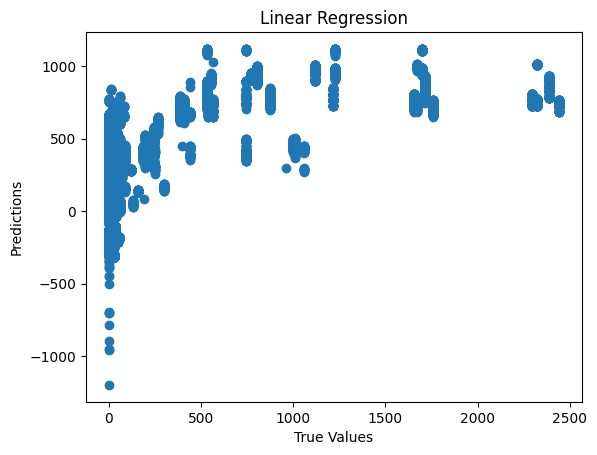

In [16]:
# visualizing the results
plot_predictions(y_test, lr_y_pred, 'Linear Regression', 'TransactionHistory_ActualCost', 'lr')

In [17]:
# dataframe with the predictions and the actual values, plus other metrics
lr_results = pd.DataFrame({'Actual': y_test, 'Predicted': lr_y_pred})
lr_results['Difference'] = lr_results['Actual'] - lr_results['Predicted']
lr_results['Absolute Difference'] = np.abs(lr_results['Difference'])
lr_results['Squared Difference'] = lr_results['Difference'] ** 2

lr_results

,Actual,Predicted,Difference,Absolute Difference,Squared Difference
103837,4.9900,195.125374,-190.135374,190.135374,3.615146e+04
89650,2319.9900,723.780184,1596.209816,1596.209816,2.547886e+06
47723,0.0000,27.379440,-27.379440,27.379440,7.496337e+02
81859,0.0000,452.111330,-452.111330,452.111330,2.044047e+05
102098,0.0000,138.899882,-138.899882,138.899882,1.929318e+04
...,...,...,...,...,...
56479,69.9900,324.304987,-254.314987,254.314987,6.467611e+04
83567,53.9900,255.030681,-201.040681,201.040681,4.041736e+04
28095,0.0000,328.064937,-328.064937,328.064937,1.076266e+05
31710,14.9776,478.654849,-463.677249,463.677249,2.149966e+05


In [ ]:
# printing the average absolute difference
print(f'Average Absolute Difference: {lr_results["Absolute Difference"].mean()}')

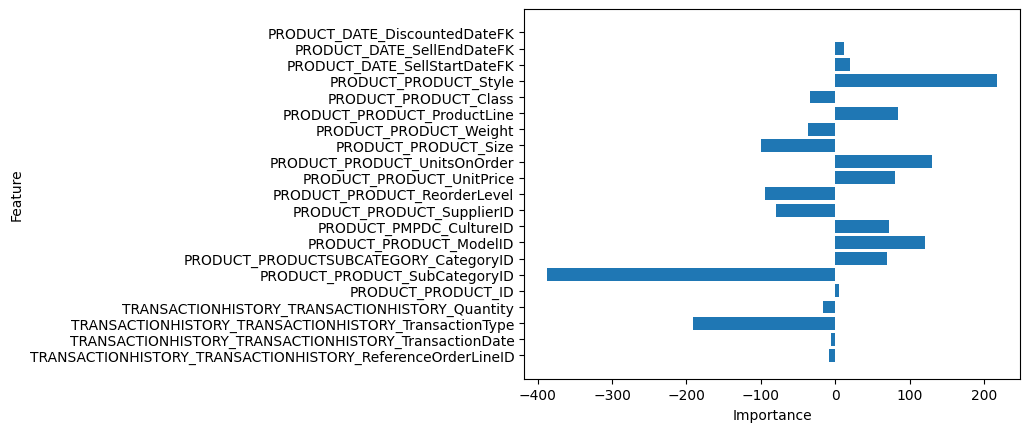

In [18]:
# plotting the feature importances, which means how much each column contributes to the prediction
plot_feature_importance(X.columns, lr_model.coef_, 'Linear Regression' ,'TransactionHistory_ActualCost', 'lr')

### Decision Tree

In [19]:
# fitting the model
dtr_model = DecisionTreeRegressor(max_depth=5)

dtr_model.fit(X_train_scaled, y_train)

DecisionTreeRegressor(max_depth=5)

In [20]:
# predicting the values
dtr_y_pred = dtr_model.predict(X_test_scaled)

#### Calculating the metrics and visualizing the data

In [21]:
# calculating the metrics
dtr_mse = mean_squared_error(y_test, dtr_y_pred)
dtr_r2 = r2_score(y_test, dtr_y_pred)
print(f'Mean Squared Error: {dtr_mse}')
print(f'R2 Score: {dtr_r2}')

Mean Squared Error: 6001.720968485642
R2 Score: 0.9805783684047383


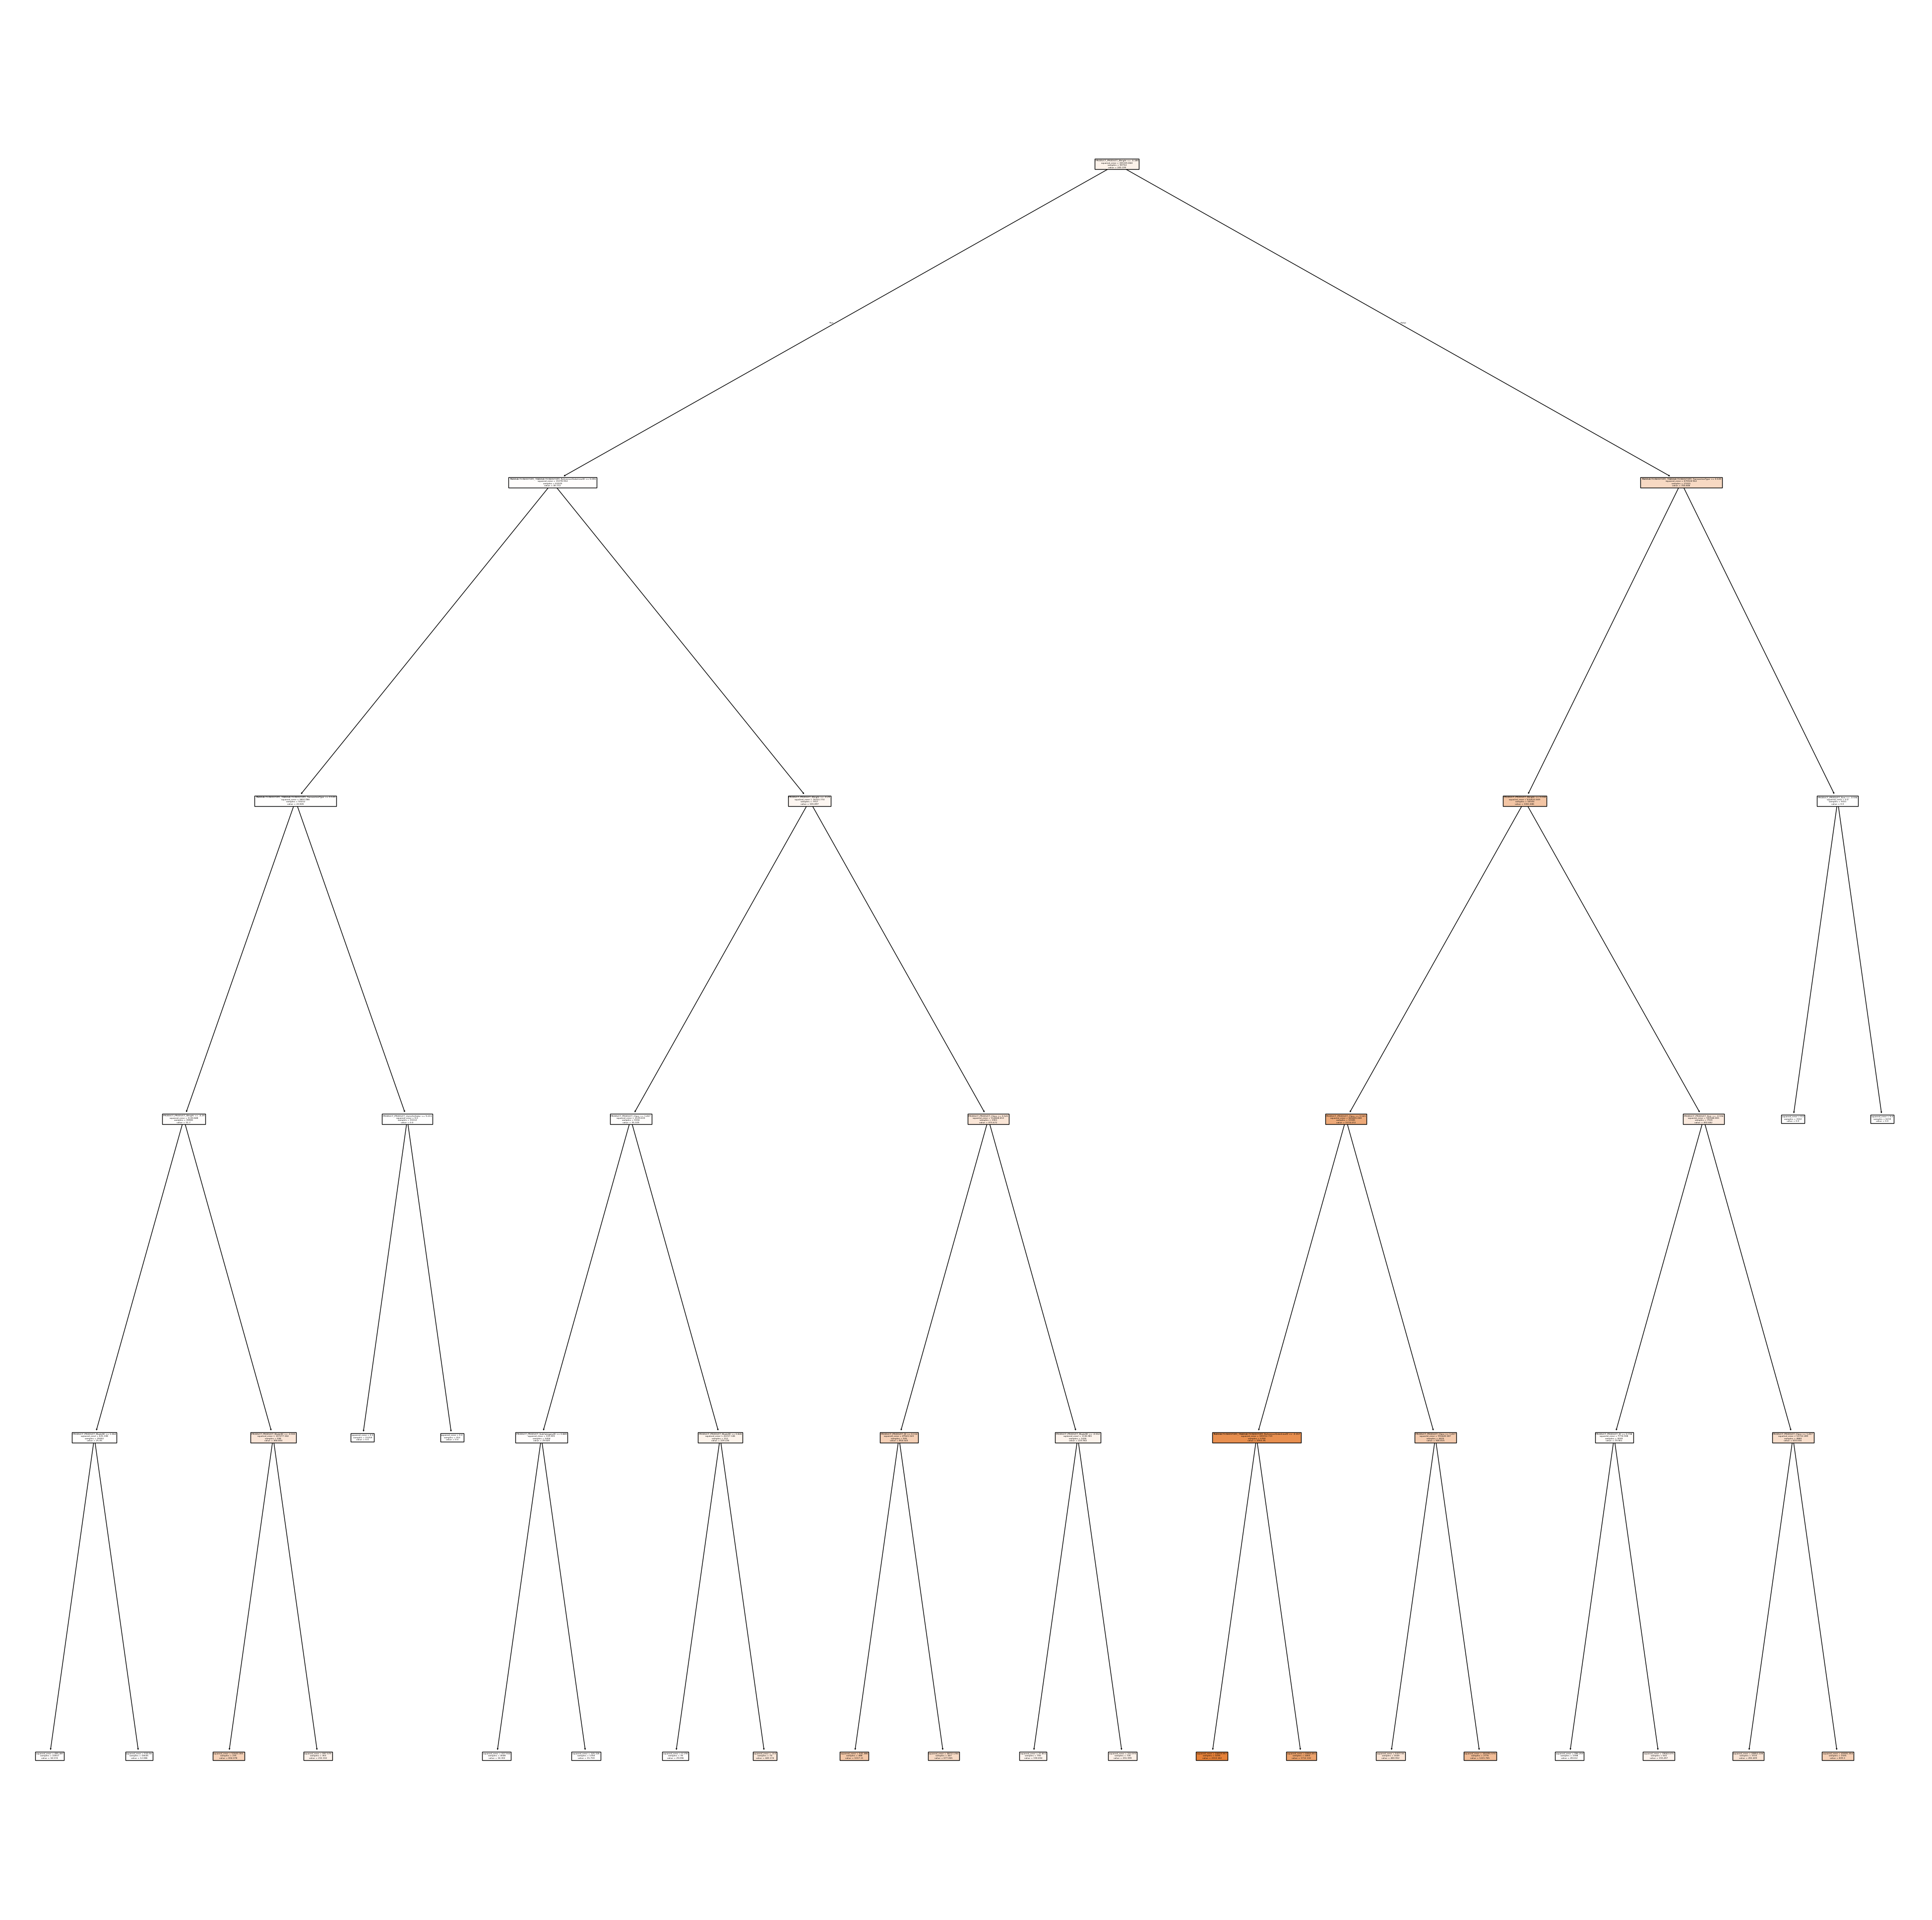

In [22]:
# visualizing the decision tree
plot_decision_tree(dtr_model, X.columns, 'Decision Tree', 'TransactionHistory_ActualCost', 'dt')

In [23]:
# dataframe with the predictions and the actual values, plus other metrics
dtr_results = pd.DataFrame({'Actual': y_test, 'Predicted': dtr_y_pred})
dtr_results['Difference'] = dtr_results['Actual'] - dtr_results['Predicted']
dtr_results['Absolute Difference'] = np.abs(dtr_results['Difference'])
dtr_results['Squared Difference'] = dtr_results['Difference'] ** 2

dtr_results

,Actual,Predicted,Difference,Absolute Difference,Squared Difference
103837,4.9900,12.085765,-7.095765,7.095765,50.349880
89650,2319.9900,2313.161554,6.828446,6.828446,46.627678
47723,0.0000,0.000000,0.000000,0.000000,0.000000
81859,0.0000,0.000000,0.000000,0.000000,0.000000
102098,0.0000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...
56479,69.9900,34.573634,35.416366,35.416366,1254.318996
83567,53.9900,34.573634,19.416366,19.416366,376.995277
28095,0.0000,0.000000,0.000000,0.000000,0.000000
31710,14.9776,34.302136,-19.324536,19.324536,373.437675


In [ ]:
# printing the average absolute difference
print(f'Average Absolute Difference: {dtr_results["Absolute Difference"].mean()}')

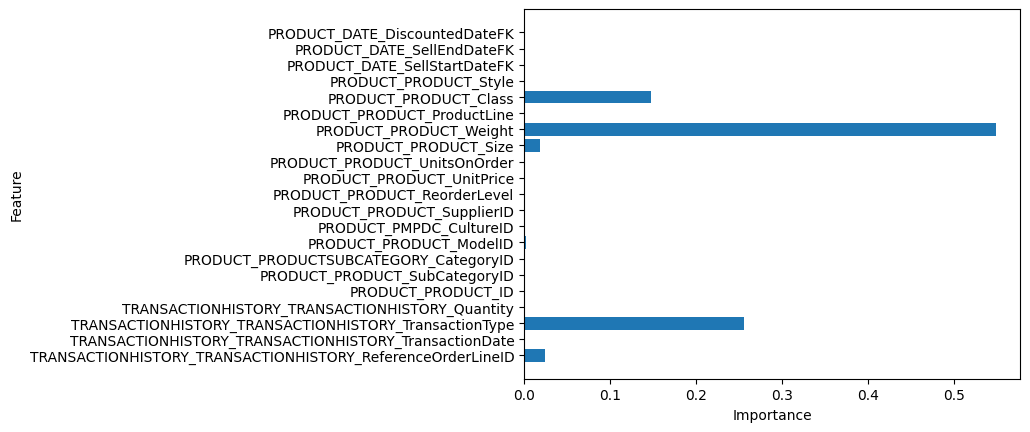

In [24]:
# plotting the feature importances, which means how much each column contributes to the prediction
plot_feature_importance(X.columns, dtr_model.feature_importances_, 'Decision Tree', 'TransactionHistory_ActualCost', 'dt')

### Random Forest

In [25]:
# fitting the model
rfr_model = RandomForestRegressor(n_estimators=500)

rfr_model.fit(X_train_scaled, y_train)

RandomForestRegressor(n_estimators=500)

In [26]:
# predicting the values
rfr_y_pred = rfr_model.predict(X_test_scaled)

#### Calculating the metrics and visualizing the data

In [27]:
# calculating the metrics
rfr_mse = mean_squared_error(y_test, rfr_y_pred)
rfr_r2 = r2_score(y_test, rfr_y_pred)
print(f'Mean Squared Error: {rfr_mse}')
print(f'R2 Score: {rfr_r2}')

Mean Squared Error: 592.9605393405728
R2 Score: 0.9980811735157181


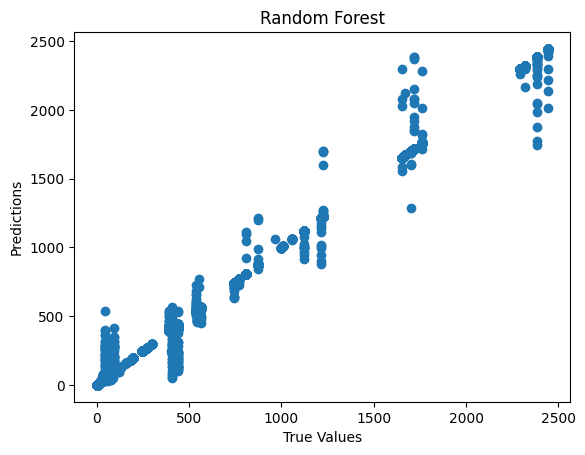

In [28]:
# plotting the results
plot_predictions(y_test, rfr_y_pred, 'Random Forest', 'TransactionHistory_ActualCost', 'rf')

In [29]:
# dataframe with the predictions and the actual values, plus other metrics
rfr_results = pd.DataFrame({'Actual': y_test, 'Predicted': rfr_y_pred})
rfr_results['Difference'] = rfr_results['Actual'] - rfr_results['Predicted']
rfr_results['Absolute Difference'] = np.abs(rfr_results['Difference'])
rfr_results['Squared Difference'] = rfr_results['Difference'] ** 2

rfr_results

,Actual,Predicted,Difference,Absolute Difference,Squared Difference
103837,4.9900,4.9900,3.375078e-14,3.375078e-14,1.139115e-27
89650,2319.9900,2319.9900,8.640200e-12,8.640200e-12,7.465305e-23
47723,0.0000,0.0000,0.000000e+00,0.000000e+00,0.000000e+00
81859,0.0000,0.0000,0.000000e+00,0.000000e+00,0.000000e+00
102098,0.0000,0.0000,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...
56479,69.9900,69.9900,-5.400125e-13,5.400125e-13,2.916135e-25
83567,53.9900,53.9900,-5.542233e-13,5.542233e-13,3.071635e-25
28095,0.0000,0.0000,0.000000e+00,0.000000e+00,0.000000e+00
31710,14.9776,14.9776,-1.136868e-13,1.136868e-13,1.292470e-26


In [ ]:
# printing the average absolute difference
print(f'Average Absolute Difference: {rfr_results["Absolute Difference"].mean()}')

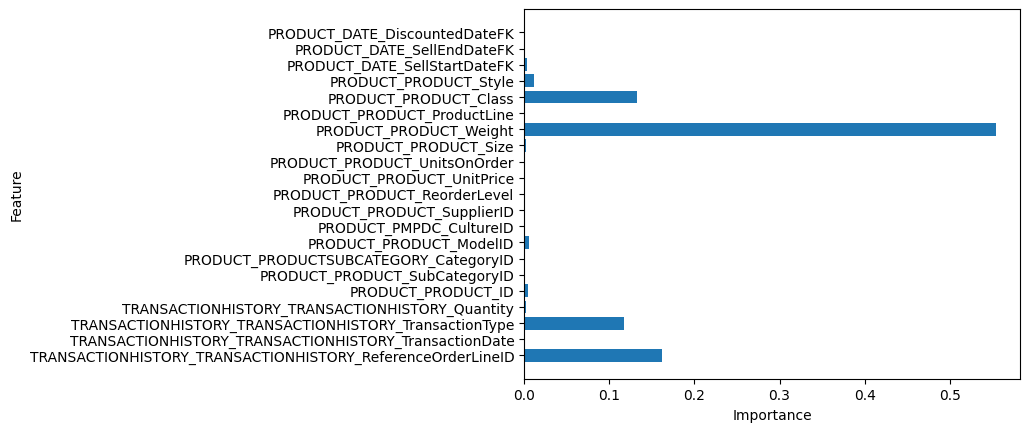

In [30]:
# plotting the feature importances, which means how much each column contributes to the prediction
plot_feature_importance(X.columns, rfr_model.feature_importances_, 'Random Forest', 'TransactionHistory_ActualCost', 'rf')

### Gradient Boosting

In [31]:
# fitting the model
gbr_model = GradientBoostingRegressor(n_estimators=500)

gbr_model.fit(X_train_scaled, y_train)

GradientBoostingRegressor(n_estimators=500)

In [32]:
# predicting the values
gbr_y_pred = gbr_model.predict(X_test_scaled)

#### Calculating the metrics and visualizing the data

In [33]:
# calculating the metrics
gbr_mse = mean_squared_error(y_test, gbr_y_pred)
gbr_r2 = r2_score(y_test, gbr_y_pred)
print(f'Mean Squared Error: {gbr_mse}')
print(f'R2 Score: {gbr_r2}')

Mean Squared Error: 1881.3879184795426
R2 Score: 0.9939118090907006


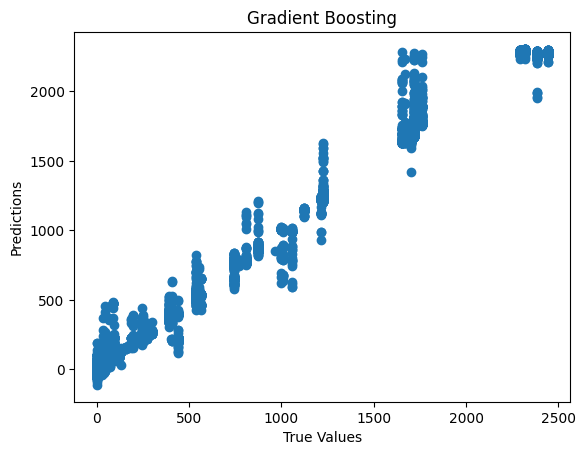

In [34]:
# plotting the results
plot_predictions(y_test, gbr_y_pred, 'Gradient Boosting', 'TransactionHistory_ActualCost', 'gb')

In [35]:
# dataframe with the predictions and the actual values, plus other metrics
gbr_results = pd.DataFrame({'Actual': y_test, 'Predicted': gbr_y_pred})
gbr_results['Difference'] = gbr_results['Actual'] - gbr_results['Predicted']
gbr_results['Absolute Difference'] = np.abs(gbr_results['Difference'])
gbr_results['Squared Difference'] = gbr_results['Difference'] ** 2

gbr_results

,Actual,Predicted,Difference,Absolute Difference,Squared Difference
103837,4.9900,7.105569,-2.115569,2.115569,4.475631
89650,2319.9900,2302.057781,17.932219,17.932219,321.564491
47723,0.0000,-16.968538,16.968538,16.968538,287.931278
81859,0.0000,36.790167,-36.790167,36.790167,1353.516357
102098,0.0000,-7.077855,7.077855,7.077855,50.096026
...,...,...,...,...,...
56479,69.9900,77.646294,-7.656294,7.656294,58.618844
83567,53.9900,51.256190,2.733810,2.733810,7.473715
28095,0.0000,-11.016449,11.016449,11.016449,121.362158
31710,14.9776,20.534659,-5.557059,5.557059,30.880907


In [ ]:
# printing the average absolute difference
print(f'Average Absolute Difference: {gbr_results["Absolute Difference"].mean()}')

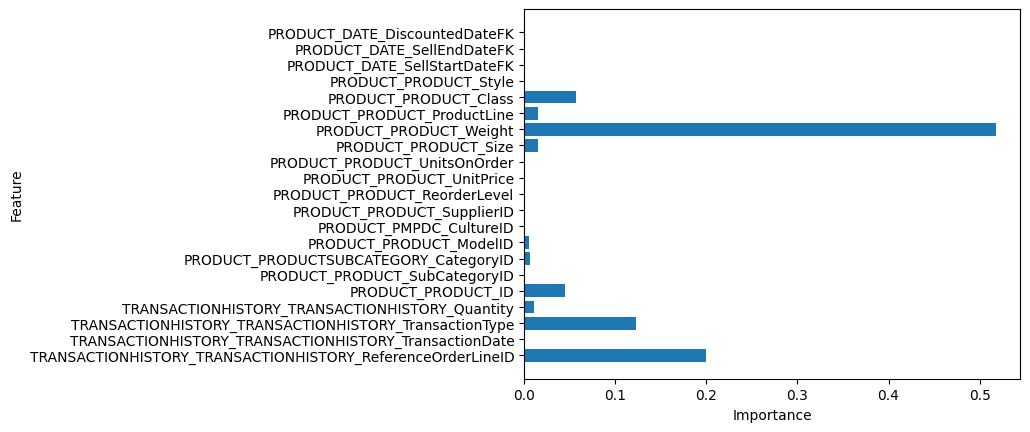

In [36]:
# plotting the feature importances, which means how much each column contributes to the prediction
plot_feature_importance(X.columns, gbr_model.feature_importances_, 'Gradient Boosting', 'TransactionHistory_ActualCost', 'gb')

### Neural Network

In [37]:
# check if the GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# converting the scaled data to tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)  # target variable often doesn't need scaling
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

Using device: cuda


In [38]:
# instantiate the model
p_model = torch.nn.Sequential(
    torch.nn.Linear(X_train_tensor.shape[1], 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 16),
    torch.nn.ReLU(),
    torch.nn.Linear(16, 1)
).to(device)

# define the loss function and the optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(p_model.parameters(), lr=0.01)

# Create TensorDatasets for training and test data
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders for training and test data
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

# Train the model
train_model(p_model, criterion, optimizer, train_loader, num_epochs=200)

Epoch 0, Loss: 49.298099517822266
Epoch 100, Loss: 0.1362164169549942


#### Calculating the metrics and visualizing the data

In [39]:
# Evaluate the model
p_model.eval()
p_mse_list = []
p_r2_list = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = p_model(inputs)
        mse = mean_squared_error(targets.cpu().detach().numpy(), outputs.cpu().detach().numpy())
        p_mse_list.append(mse)
        
        # Only calculate R^2 score if there are more than one samples
        if len(targets) > 1:
            r2 = r2_score(targets.cpu().detach().numpy(), outputs.cpu().detach().numpy())
            p_r2_list.append(r2)

# Calculate the average metrics
p_avg_mse = np.mean(p_mse_list)
p_avg_r2 = np.mean(p_r2_list) if p_r2_list else None

print(f'Average Mean Squared Error: {p_avg_mse}')
print(f'Average R2 Score: {p_avg_r2}')

Average Mean Squared Error: 1391.1739501953125
Average R2 Score: 0.9942342269067536


In [40]:
# dataframe with the predictions and the actual values, plus other metrics
p_results = pd.DataFrame({'Actual': y_test_tensor.cpu().detach().numpy(), 'Predicted': p_model(X_test_tensor).cpu().detach().numpy().flatten()})
p_results['Difference'] = p_results['Actual'] - p_results['Predicted']
p_results['Absolute Difference'] = np.abs(p_results['Difference'])
p_results['Squared Difference'] = p_results['Difference'] ** 2

p_results

,Actual,Predicted,Difference,Absolute Difference,Squared Difference
0,4.990000,2.182853,2.807146,2.807146,7.880070
1,2319.989990,2342.168701,-22.178711,22.178711,491.895233
2,0.000000,0.396248,-0.396248,0.396248,0.157012
3,0.000000,0.396248,-0.396248,0.396248,0.157012
4,0.000000,0.396248,-0.396248,0.396248,0.157012
...,...,...,...,...,...
22684,69.989998,60.111092,9.878906,9.878906,97.592789
22685,53.990002,44.116096,9.873905,9.873905,97.494003
22686,0.000000,0.396248,-0.396248,0.396248,0.157012
22687,14.977600,44.245979,-29.268379,29.268379,856.638000


In [41]:
# printing the average absolute difference
print(f'Average Absolute Difference: {p_results["Absolute Difference"].mean()}')

Average Absolute Difference: 12.571820259094238


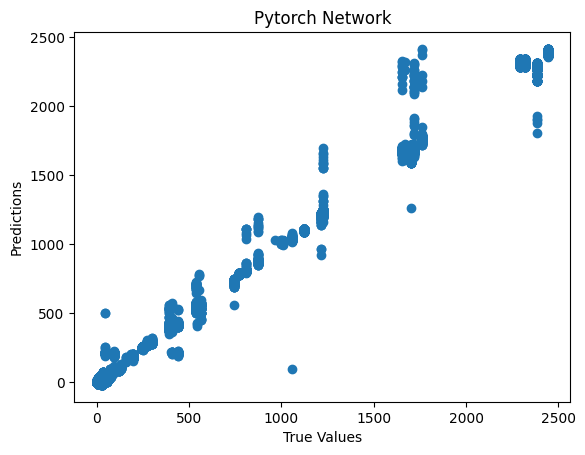

In [42]:
# plotting the results
plot_predictions(y_test_tensor.cpu().detach().numpy(), p_model(X_test_tensor).cpu().detach().numpy().flatten(), 'Pytorch Network', 'TransactionHistory_ActualCost', 'torch')